In this assignment, you will be implementing a GPT model and train it using CLM objective.
 * If you get stuck at something or need more clarrifications, you may refer to : https://github.com/karpathy/minGPT/blob/master/mingpt/model.py

 * We will be using ReLU activation function instead of GELU.

 * As usual, let us install the required libraries

 * **Note** that if you are not getting the exact loss values as mentioned in this notebook, that is absolutely fine. Just see whether your implementation overfits the given toy-and-tiny paragraph!

# Installation


In [ ]:
!pip install torchdata==0.6.0
!pip install portalocker==2.0.0

* See [here](https://github.com/pytorch/text) for compatability

In [ ]:
!pip install -U torchtext==0.15.1

# Imports

In [ ]:
import torch
from torch import Tensor
import math

import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.nn.functional import one_hot

import torch.optim as optim

#text lib
import torchtext

# tokenizer
from torchtext.data.utils import get_tokenizer

#build vocabulary
from torchtext.vocab import vocab
from torchtext.vocab import build_vocab_from_iterator

# get input_ids (numericalization)
from torchtext.transforms import VocabTransform

# get embeddings
from torch.nn import Embedding

from  pprint import pprint
from yaml import safe_load
import copy
import numpy as np

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

# Load the dataset for LM modeling

 * We use a simple tokenizer and put

In [ ]:
batch_size = 10

In [ ]:
class Tokenizer(object):

  def __init__(self,text):
    self.text = text
    self.word_tokenizer = get_tokenizer(tokenizer="basic_english",language='en')
    self.vocab_size = None

  def get_tokens(self):
    for sentence in self.text.strip().split('\n'):
      yield self.word_tokenizer(sentence)

  def build_vocab(self):
    v = build_vocab_from_iterator(self.get_tokens(),
                                  min_freq=1,specials=['<unk>','<start>','<end>'])
    v.set_default_index(v['<unk>']) # index of OOV
    self.vocab_size = len(v)
    return v

  def token_ids(self):
    v = self.build_vocab()
    vt = VocabTransform(v)
    num_tokens = len(self.word_tokenizer(self.text))
    max_seq_len = np.ceil(num_tokens/batch_size)
    data = torch.zeros(size=(1,num_tokens))
    data = vt(self.word_tokenizer(self.text))
    data = torch.tensor(data,dtype=torch.int64)
    return data.reshape(batch_size,torch.tensor(max_seq_len,dtype=torch.int64))



In [ ]:
text = """Best known for the invention of Error Correcting Codes, he was a true polymath who applied his mathematical and problem-solving skills to numerous disciplines.
Reflecting on the significant benefits I received from Hamming, I decided to develop a tribute to his legacy. There has not been a previous biography of Hamming, and the few articles about him restate known facts and assumptions and leave us with open questions.
One thought drove me as I developed this legacy project: An individual's legacy is more than a list of their attempts and accomplishments. Their tribute should also reveal the succeeding generations they inspired and enabled and what each attempted and achieved.
This book is a unique genre containing my version of a biography that intertwines the story "of a life" and a multi-player memoir with particular events and turning points recalled by those, including me, who he inspired and enabled.
Five years of research uncovered the people, places, opportunities, events, and influences that shaped Hamming. I discovered unpublished information, stories, photographs, videos, and personal remembrances to chronicle his life, which helped me put Hamming's
legacy in the context I wanted.The result demonstrates many exceptional qualities, including his noble pursuit of excellence and helping others. Hamming paid attention to the details, his writings continue to influence, and his guidance is a timeless gift to the world.
This biography is part of """

In [ ]:
# Split the text by '.'
sentences = text.split('.')
sentences

['Best known for the invention of Error Correcting Codes, he was a true polymath who applied his mathematical and problem-solving skills to numerous disciplines',
 '\nReflecting on the significant benefits I received from Hamming, I decided to develop a tribute to his legacy',
 ' There has not been a previous biography of Hamming, and the few articles about him restate known facts and assumptions and leave us with open questions',
 "\nOne thought drove me as I developed this legacy project: An individual's legacy is more than a list of their attempts and accomplishments",
 ' Their tribute should also reveal the succeeding generations they inspired and enabled and what each attempted and achieved',
 '\nThis book is a unique genre containing my version of a biography that intertwines the story "of a life" and a multi-player memoir with particular events and turning points recalled by those, including me, who he inspired and enabled',
 '\nFive years of research uncovered the people, place

In [ ]:
Tk = Tokenizer(text)


In [ ]:
x_raw = Tk.token_ids()
print(x_raw.shape)
print(x_raw)

torch.Size([10, 26])
tensor([[ 46,  24,  70,   6,  86,   8,  64,  54,  50,   3,  21, 149,   7, 140,
         111,  30,  37,  10,  90,   4, 113, 130,   9,  97,  60,   5],
        [121,  98,   6, 129,  45,  12, 120,  71,  11,   3,  12,  55,   9,  58,
           7,  29,   9,  10,  14,   5, 135,  76,  96,  44,   7, 112],
        [ 15,   8,  11,   3,   4,   6,  68,  38,  32,  79, 124,  24,  67,   4,
          40,   4,  87, 145,  31, 100, 118,   5,  99, 138,  62,  16],
        [ 39,  12,  59,  17,  14, 114,  36,  81,  18,  26,  14,  13,  92, 134,
           7,  88,   8,  28,  42,   4,  33,   5,  28,  29, 128,  35],
        [126,   6, 133,  72, 136,  23,   4,  19,   4, 150,  63,  41,   4,  34,
           5,  17,  47,  13,   7, 143,  73,  51,  94, 146,   8,   7],
        [ 15,  27,  85,   6, 132,   8,   7,  25,   4,   7,  93,  91,  31, 105,
          20,   4, 141, 110, 119,  48, 137,   3,  22,  16,   3,  30],
        [ 21,  23,   4,  19,   5,  69, 154,   8, 123, 142,   6, 106,   3, 109,
      

In [ ]:
# let us display the first 10 tokens of the vocabulary
vocab = Tk.build_vocab()
pprint(vocab.vocab.get_itos()[0:10])

['<unk>', '<start>', '<end>', ',', 'and', '.', 'the', 'a', 'of', 'to']


In [ ]:
print(len(vocab), vocab.get_itos()[0:-1])

155 ['<unk>', '<start>', '<end>', ',', 'and', '.', 'the', 'a', 'of', 'to', 'his', 'hamming', 'i', 'is', 'legacy', 'biography', 'me', 'this', "'", 'enabled', 'events', 'he', 'including', 'inspired', 'known', 'life', 's', 'that', 'their', 'tribute', 'who', 'with', 'about', 'accomplishments', 'achieved', 'also', 'an', 'applied', 'articles', 'as', 'assumptions', 'attempted', 'attempts', 'attention', 'been', 'benefits', 'best', 'book', 'by', 'chronicle', 'codes', 'containing', 'context', 'continue', 'correcting', 'decided', 'demonstrates', 'details', 'develop', 'developed', 'disciplines', 'discovered', 'drove', 'each', 'error', 'excellence', 'exceptional', 'facts', 'few', 'five', 'for', 'from', 'generations', 'genre', 'gift', 'guidance', 'has', 'helped', 'helping', 'him', 'in', 'individual', 'influence', 'influences', 'information', 'intertwines', 'invention', 'leave', 'list', 'many', 'mathematical', 'memoir', 'more', 'multi-player', 'my', 'noble', 'not', 'numerous', 'on', 'one', 'open', 'o

* Create the input_ids and Labels from the raw input sequence

In [ ]:
bs,raw_seq_len = x_raw.shape
x = torch.empty(size=(bs,raw_seq_len+2),dtype=torch.int64)
x[:,1:-1] =x_raw

# insert the index of special tokens
x[:,0] = torch.full(size=(1,batch_size),fill_value=vocab.vocab.get_stoi()['<start>'])
x[:,-1] = torch.full(size=(1,batch_size),fill_value=vocab.vocab.get_stoi()['<end>'])

#Quickly check implem
vocab = Tk.build_vocab()
words = []
for idx in x[0,:]:
  words.append(vocab.vocab.get_itos()[idx.item()])
print(' '.join(words))

<start> best known for the invention of error correcting codes , he was a true polymath who applied his mathematical and problem-solving skills to numerous disciplines . <end>


In [ ]:
# labels are just the input_ids shifted by right
bs,seq_len = x.shape
y = torch.empty(size=(bs,seq_len),dtype=torch.int64)
y[:,0:-1] = copy.deepcopy(x[:,1:])

#ignore the index of padded tokens while computing loss
y[:,-1] = torch.full(size=(1,batch_size),fill_value=-100)

In [ ]:
print(f"Initial input is {x} and its shape is {x.shape}")
print(f"Expected output is {y} and its shape is {y.shape}")

Initial input is tensor([[  1,  46,  24,  70,   6,  86,   8,  64,  54,  50,   3,  21, 149,   7,
         140, 111,  30,  37,  10,  90,   4, 113, 130,   9,  97,  60,   5,   2],
        [  1, 121,  98,   6, 129,  45,  12, 120,  71,  11,   3,  12,  55,   9,
          58,   7,  29,   9,  10,  14,   5, 135,  76,  96,  44,   7, 112,   2],
        [  1,  15,   8,  11,   3,   4,   6,  68,  38,  32,  79, 124,  24,  67,
           4,  40,   4,  87, 145,  31, 100, 118,   5,  99, 138,  62,  16,   2],
        [  1,  39,  12,  59,  17,  14, 114,  36,  81,  18,  26,  14,  13,  92,
         134,   7,  88,   8,  28,  42,   4,  33,   5,  28,  29, 128,  35,   2],
        [  1, 126,   6, 133,  72, 136,  23,   4,  19,   4, 150,  63,  41,   4,
          34,   5,  17,  47,  13,   7, 143,  73,  51,  94, 146,   8,   7,   2],
        [  1,  15,  27,  85,   6, 132,   8,   7,  25,   4,   7,  93,  91,  31,
         105,  20,   4, 141, 110, 119,  48, 137,   3,  22,  16,   3,  30,   2],
        [  1,  21,  23,   4, 

# Configuration

In [ ]:
vocab_size = Tk.vocab_size
seq_len = x.shape[1]
embed_dim = 32
dmodel = embed_dim
dq = torch.tensor(4)
dk = torch.tensor(4)
dv = torch.tensor(4)
heads = torch.tensor(8)
d_ff = 4*dmodel
print(f"Vocab size is {vocab_size}, seq_len is {seq_len}, embed_dim and dmodel is {dmodel}, dq, dk and dv are {dq}, no. of heads are{heads}, dff is {d_ff}")

Vocab size is 155, seq_len is 28, embed_dim and dmodel is 32, dq, dk and dv are 4, no. of heads are8, dff is 128


* Define all the sub-layers (mhma,ffn) in the transformer blocks
* Seed for $W_Q,W_K,W_V,W_O$, 43, 44 and 45, 46, respectively
* Seed for ffn $W_1,W_2$,  47 and 48. There are no biases
* Seed for output layer 49

In [ ]:
class MHMA(nn.Module):
    def __init__(self, d_model, dq, dk, dv, heads):
        super(MHMA, self).__init__()

        self.d_model = d_model  # Model dimension (output dimension)
        self.heads = heads  # Number of attention heads
        self.dq = dq  # Query dimension per head
        self.dk = dk  # Key dimension per head
        self.dv = dv  # Value dimension per head

        # Initialize the weight matrices
        self.W_q = nn.Parameter(torch.randn((heads, d_model, dq), generator=torch.manual_seed(43)))
        self.W_k = nn.Parameter(torch.randn((heads, d_model, dk), generator=torch.manual_seed(44)))
        self.W_v = nn.Parameter(torch.randn((heads, d_model, dv), generator=torch.manual_seed(45)))
        self.W_o = nn.Parameter(torch.randn((d_model, d_model), generator=torch.manual_seed(46)))

        # Xavier initialization
        nn.init.xavier_uniform_(self.W_q)
        nn.init.xavier_uniform_(self.W_k)
        nn.init.xavier_uniform_(self.W_v)
        nn.init.xavier_uniform_(self.W_o)

        # Attention head size
        self.attn_head_size = self.dk  # Typically dk == dq == dv per head

    def forward(self, Q, K, V, mask=None):
        BS, T, _ = Q.shape
        #print(f"Q shape: {Q.shape}, K shape: {K.shape}, V shape: {V.shape}")  # Debugging line
        Q = torch.einsum('BTM, HMQ -> BHTQ', Q, self.W_q)
        K = torch.einsum('BTM, HMK -> BHTK', K, self.W_k)
        V = torch.einsum('BTM, HMV -> BHTV', V, self.W_v)
        #print(f"Transformed Q shape: {Q.shape}, K shape: {K.shape}, V shape: {V.shape}")  # Debugging line
        # Handle the case when mask is None during inference
        if mask is not None:
            #print(f"Mask in use and its shape is {mask.shape}")
            attn_score = torch.matmul(F.softmax((torch.matmul(Q, torch.transpose(K, -2, -1)) + mask) / math.sqrt(self.dq), dim=-1), V)
        else:
            #print(" No Masking")
            attn_score = torch.matmul(F.softmax(torch.matmul(Q, torch.transpose(K, -2, -1)) / math.sqrt(self.dq), dim=-1), V)
        #print(f"Attention score shappe is {attn_score.shape}")
        combined_attn = attn_score.permute(0, 2, 1, 3).contiguous().view(BS, T, -1)
        out = torch.matmul(combined_attn, self.W_o)
        #print(f"Final output from MHMA shape is {out.shape}")
        return out


In [ ]:
class FFN(nn.Module):
    def __init__(self, dmodel, d_ff):
        super(FFN, self).__init__()
        torch.manual_seed(47)
        self.W1 = nn.Linear(dmodel, d_ff, bias=False)
        torch.manual_seed(48)
        self.W2 = nn.Linear(d_ff, dmodel, bias=False)

    def forward(self, x):
        return self.W2(F.relu(self.W1(x)))


In [ ]:
class PredictionHead(nn.Module):
    def __init__(self, dmodel, vocab_size):
        super(PredictionHead, self).__init__()
        torch.manual_seed(49)
        self.proj = nn.Linear(dmodel, vocab_size, bias=False)

    def forward(self, x):
        return self.proj(x)


In [ ]:
class PositionalHead(nn.Module):
    def __init__(self, dmodel, max_seq_len=512):
        super(PositionalHead, self).__init__()
        self.dmodel = dmodel

        # Compute positional encodings once for all positions
        pe = torch.zeros(max_seq_len, dmodel)
        position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, dmodel, 2).float() * (-torch.log(torch.tensor(10000.0)) / dmodel))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]


In [ ]:
### Creating mask for training
mask = (torch.triu(torch.ones(seq_len,seq_len)) == 1).transpose(0,1)
mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
#print(mask)

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, dmodel, dq, dk, dv, d_ff, heads):
        super(DecoderLayer, self).__init__()
        self.mhma = MHMA(dmodel, dq, dk, dv, heads)  # Masked MHMA
        self.layer_norm_1 = nn.LayerNorm(dmodel)
        self.ffn = FFN(dmodel, d_ff)
        self.layer_norm_2 = nn.LayerNorm(dmodel)

    def forward(self, dec_rep, mask):
        """
        dec_rep: (batch_size, seq_len, dmodel)
        """
        # Multi-Head Masked Attention
        mhma_output = self.mhma(dec_rep,dec_rep, dec_rep,  mask)
        # Add & Norm
        x = self.layer_norm_1(dec_rep + mhma_output)

        # Feed-Forward Network
        ffn_output = self.ffn(x)
        # Add & Norm
        out = self.layer_norm_2(x + ffn_output)

        return out


In [ ]:
class Embed(nn.Module):
    def __init__(self, vocab_size, embed_dim, seed=70):
        super(Embed, self).__init__()

        # Set the seed for reproducibility
        torch.manual_seed(70)

        # Define the embedding layer
        self.embed = nn.Embedding(vocab_size, embed_dim)  # Embedding for converting tokens to vectors

        # Initialize the embedding weights using the seed
        #nn.init.normal_(self.embed.weight, mean=0, std=0.1)  # You can use any initialization method here

        # Define the positional encoding layer
        self.pe = PositionalHead(embed_dim)  # Positional encoding to inject position information

    def forward(self, x):
        # Apply embedding and then positional encoding
        out = self.pe(self.embed(x))  # First get the embeddings, then apply positional encoding
        return out

In [ ]:
class Decoder(nn.Module):

  def __init__(self,vocab_size,dmodel,dq,dk,dv,d_ff,heads,num_layers=1):
    super(Decoder,self).__init__()
    self.embed_lookup = Embed(vocab_size,embed_dim)
    self.dec_layers = nn.ModuleList(copy.deepcopy(DecoderLayer(dmodel,dq,dk,dv,d_ff,heads)) for i in range(num_layers))
    self.predict = PredictionHead(dmodel,vocab_size)

  def forward(self,input_ids, mask):
    out = self.embed_lookup(input_ids)
    for dec_layer in self.dec_layers:
      out = dec_layer(out, mask)
    out = self.predict(out)

    return out

In [ ]:
model = Decoder(vocab_size,dmodel,dq,dk,dv,d_ff,heads)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [ ]:
def train(input_ids, labels, epochs=1000):
    # For recording loss if needed for plotting or diagnostics
    loss_trace = []
    model.train()
    for epoch in range(epochs):
        #model.train()  # Ensure the model is in training mode

        # Forward pass: Get the model output
        out = model(input_ids, mask=mask)

        # Compute the loss (cross-entropy between predicted and actual labels)
        loss = criterion(out.view(-1, vocab_size), labels.view(-1))  # Flatten for cross-entropy
        #print(f"Loss now is {loss}")
        loss_trace.append(loss.item())

        # Backward pass: Compute gradients
        loss.backward()

        # Update model parameters
        optimizer.step()

        # Zero gradients for the next step
        optimizer.zero_grad()

        # Optionally print the loss every 100 epochs
        #if (epoch + 1) % 100 == 0:
            #print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    return loss_trace




In [ ]:
# run the model for 10K epochs
loss_trace=train(x,y,10000)

In [ ]:
print(loss_trace[-1])

0.0861978530883789


The loss is about 0.09 after 10K epochs

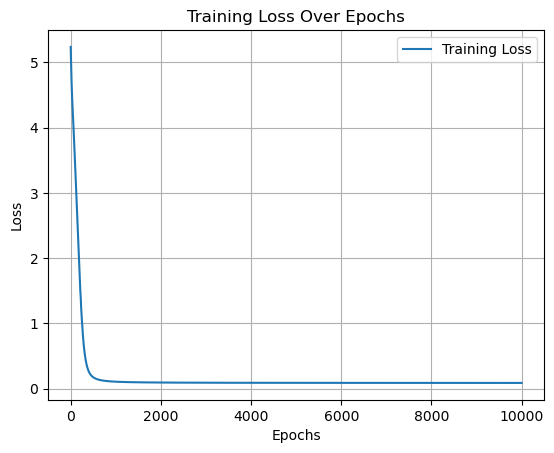

In [ ]:
import matplotlib.pyplot as plt

def plot_loss(loss_trace):
    # Create a plot of loss over epochs
    plt.plot(loss_trace, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
# Assuming loss_trace is the list of loss values returned by your train function
plot_loss(loss_trace)


# Generate text

In [ ]:
#### Not using any mask during inference

@torch.inference_mode()
def generate(model, prompt='<start>', max_words=25):
    model.eval()

    # Convert the list of tokens to token ids directly
    input_ids = torch.tensor([vocab[token] for token in prompt], dtype=torch.long).unsqueeze(0)  # Shape: [1, seq_len]

    # Start with the current input as the prompt
    generated_ids = input_ids.clone()  # This keeps track of all the generated tokens
    current_input = input_ids  # Initialize the model input as the prompt

    # Step 2: Generate the sequence token by token
    for i in range(max_words):
        # Feed the current input into the model to get the output logits
        logits = model(current_input, mask=None)  # Shape: [1, seq_len, vocab_size]

        # Get the logits of the last token in the sequence to predict the next token
        next_token_logits = logits[:, -1, :]  # Shape: [1, vocab_size]



#When we use probabilities and torch.multinomilal, everytime it picks up a different token
#and its not deterministic'''
         # Convert logits to probabilities using softmax
        #probabilities = torch.softmax(next_token_logits, dim=-1)  # Shape: [1, vocab_size]


        # Sample a token from the probability distribution
        #next_token_id = torch.multinomial(probabilities, num_samples=1)  # Shape: [1, 1]

        next_token_id = torch.argmax(next_token_logits, dim=-1, keepdim=True)  # Use argmax instead of sampling


        # Append the predicted token to the sequence
        generated_ids = torch.cat([generated_ids, next_token_id], dim=1)  # Shape: [1, seq_len + 1]

        # Update the input for the next prediction (using the entire generated sequence)
        current_input = generated_ids  # Use the entire sequence of generated tokens

        # Optionally stop if <end> token is generated
        if next_token_id.item() == vocab['<end>']:
            break  # Stop if <end> token is generated

    # Convert the generated token IDs back to words (excluding <start>)
    # Convert the generated token IDs back to words, excluding both <start> and <end>
    generated_words = [
        vocab.lookup_token(id.item()) for id in generated_ids[0]
        if id.item() not in [vocab['<start>'], vocab['<end>']]
    ]
    return ' '.join(generated_words)

In [ ]:
generate(model, prompt='<start>', max_words=25)

'<unk> s <unk> a <unk> <unk> <unk> , is more than a to influence , and . his guidance is a unique genre containing my version of'

* Note the model has memorized the sentence from the training set. Given the start token, if your implementation reproduce a sentence as is in the training set, then your implementation is likely to be correct.
* Suppose the prompt is `<start> best known`, then we expect the model to produce the first sentence as is

In [ ]:
generate(model,prompt=['<start>','best','known'],max_words=25)

'best known for the invention of error correcting codes , he was a true polymath who applied his mathematical and problem-solving skills to numerous disciplines .'

* Change the prompt

In [ ]:
generate(model,prompt=['<start>','reflecting','on'],max_words=25)

'reflecting on the significant benefits i received from hamming , i decided to develop a tribute to his legacy . there has not been a previous'